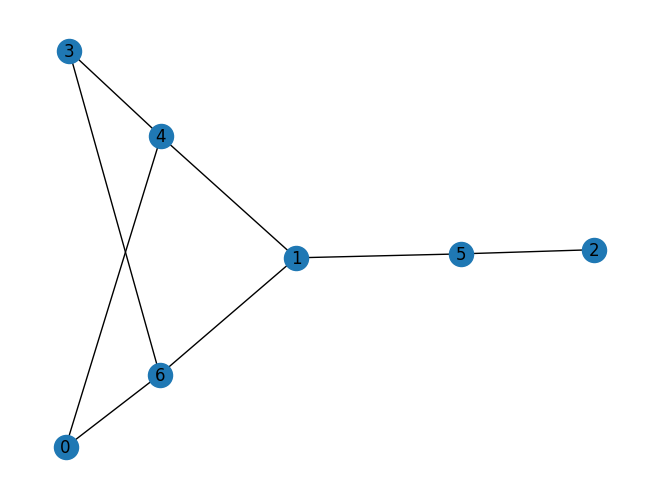

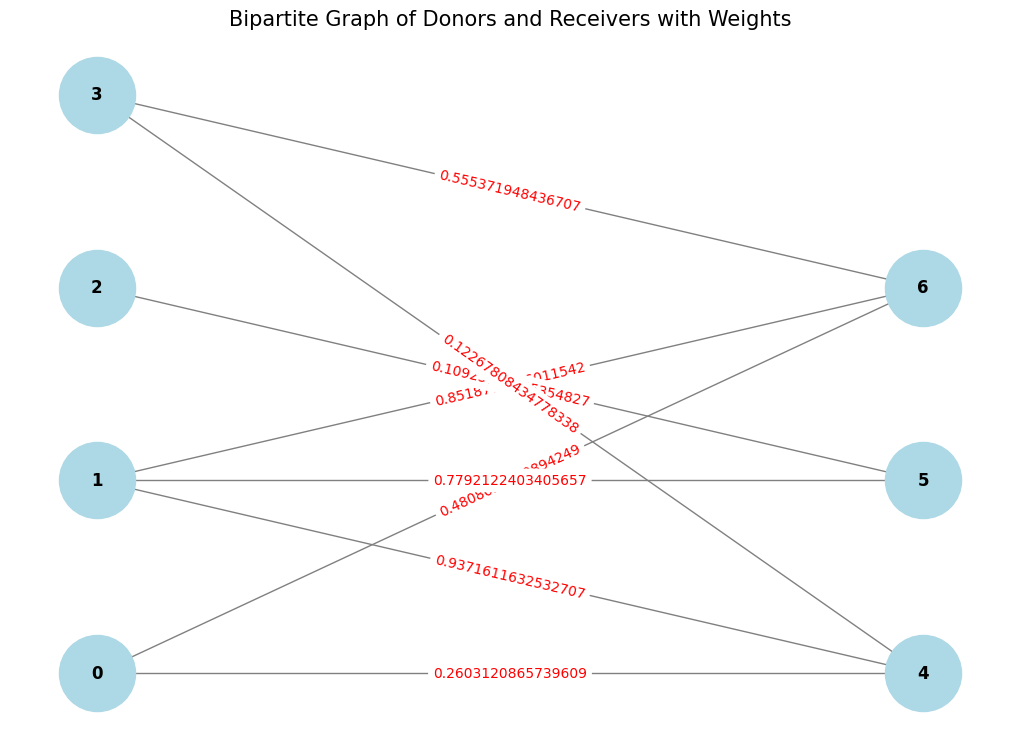

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Number of Donors and Receivers
num_donors = 4
num_receivers = 3

# Create integer-based node names
donors = list(range(num_donors))  # [0, 1, 2, 3]
receivers = list(range(num_donors, num_donors + num_receivers))  # [4, 5, 6]

# Compatibility matrix where True means a match is possible
# This can be based on medical data like blood type, etc.
compatibility = {
    (0, 4): True,
    (0, 5): False,
    (0, 6): True,
    (1, 4): True,
    (1, 5): True,
    (1, 6): True,
    (2, 4): False,
    (2, 5): True,
    (2, 6): False,
    (3, 4): True,
    (3, 5): False,
    (3, 6): True,
}
# Create a bipartite graph
B = nx.Graph()

# Add nodes with the bipartite label
B.add_nodes_from(donors, bipartite=0)
B.add_nodes_from(receivers, bipartite=1)

# Add edges based on compatibility
for donor, receiver in compatibility:
    if compatibility[(donor, receiver)]:
        B.add_edge(donor, receiver)
nx.draw(B, with_labels = True)  

pos = {}

# Assign positions to donors (left side)
for i, donor in enumerate(donors):
    pos[donor] = (-1, i)

# Assign positions to receivers (right side)
for i, receiver in enumerate(receivers):
    pos[receiver] = (1, i)
weighted = True
for (u, v) in B.edges():
    if weighted:
        w = random.uniform(0, 1)
    else:
        w = 1
    B.edges[u, v]['weight'] = w

# Draw the graph
plt.figure(figsize=(10, 7))
edge_labels = nx.get_edge_attributes(B, 'weight')
nx.draw(B, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12, font_weight='bold')
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels, font_color='red')
plt.title("Bipartite Graph of Donors and Receivers with Weights", size=15)
plt.show()

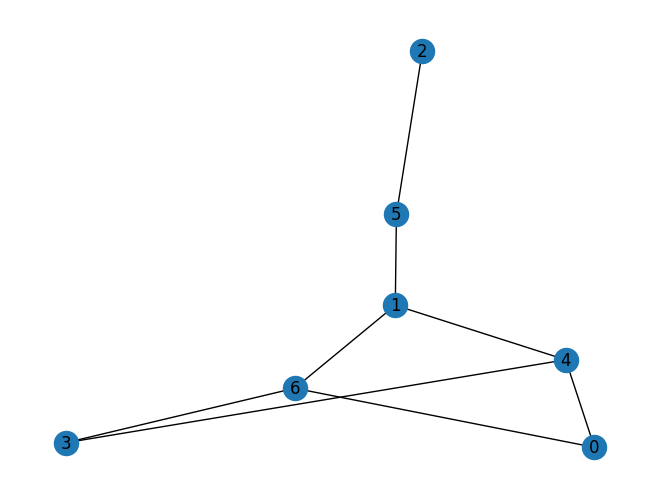

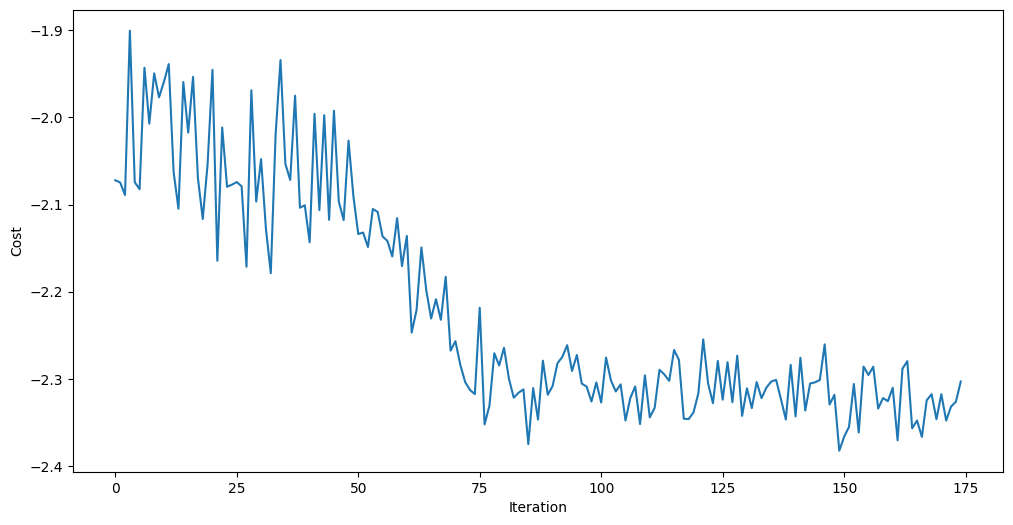

{'0001001': 9, '1101110': 7, '0011011': 5, '0111101': 7, '0100011': 4, '0001100': 6, '1110000': 34, '1001110': 26, '0111011': 21, '0100101': 4, '1001100': 8, '1110110': 3, '1010011': 18, '1100010': 6, '0011111': 19, '0000111': 7, '0110000': 45, '1000001': 6, '1111101': 12, '1110001': 15, '0100001': 1, '0111111': 3, '1110010': 7, '0011010': 33, '1100100': 3, '0001101': 12, '1110111': 17, '1001011': 7, '1011000': 6, '0010100': 6, '0010111': 21, '1110101': 4, '0111010': 3, '0100110': 3, '0001111': 16, '1111010': 6, '1000100': 8, '0101011': 11, '0110101': 14, '0000101': 10, '1111111': 1, '1000011': 4, '1011110': 25, '0010101': 37, '1111011': 7, '1000111': 5, '0000001': 9, '0011000': 12, '1010000': 3, '1011010': 17, '1101000': 4, '0000011': 7, '0110111': 18, '1100101': 12, '1100110': 4, '0011100': 7, '1001111': 20, '1110011': 8, '0100000': 20, '1011011': 8, '1010111': 4, '0111000': 7, '0010011': 14, '0000110': 11, '1111110': 1, '1000000': 12, '1110100': 28, '1100000': 18, '1010110': 5, '101

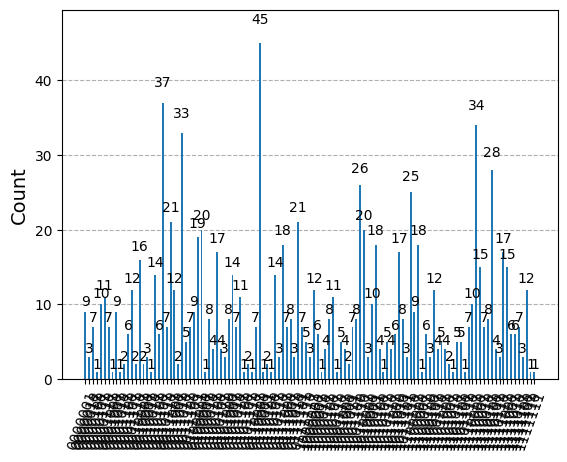

In [14]:
import networkx as nx
import numpy as np
import random
from itertools import combinations
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary, maximize
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

#service = QiskitRuntimeService(channel="ibm_quantum", token="4d675380adc3c0291ae0f7eebeb5011cf50f5ec7822256ec60f44a95eeae7a62ef3bed681f5b0ec3e8af0b30d7cb77445c71f13b9fbb90dbceb8d205dca56ad1")
#backend = service.backend(name = 'ibm_kyiv')  # Use a real quantum device if needed

#Local simulator parameters
aer_sim = AerSimulator(max_parallel_threads=10)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ['u3'])

# sorunlu graph

nx.draw(B, with_labels = True)  
weighted = True

#PYOMO parametreleri
'''
model = ConcreteModel()

# Decision variables: x[i,j] = 1 if donor i is matched with recipient j
model.x = Var(B.edges(), within=Binary)

# Objective function: maximize the total weight of connections
def objective_rule(model):
    return sum(B.edges[i, j]['weight'] * model.x[i, j] for i, j in B.edges())
model.obj = Objective(rule=objective_rule, sense=maximize)  # Minimize negative, equivalent to maximize

#Constraints: Each donor and recipient is matched only once
def donor_constraint_rule(model, i):
    return sum(model.x[i, j] for j in G.neighbors(i) if (i, j) in model.x) <= 1
model.donor_constraint = Constraint(range(donors), rule=donor_constraint_rule)

def recipient_constraint_rule(model, j):
    return sum(model.x[i, j] for i in G.neighbors(j) if (i, j) in model.x) <= 1
model.recipient_constraint = Constraint(range(donors, donors + recipients), rule=recipient_constraint_rule)
'''

#QAOA KISMI 

# QAOA parameters
depth = 8
rep = 1000
qubits = list(range(num_donors + num_receivers))

# Her qubit için bir hadamard gate
def initialization(qc, qubits):
    for q in qubits:
        qc.h(q)

# Define the cost hamiltonian (CNOT,RZ,CNOT at bağlantılı nodes)
from itertools import combinations

def compatible_receivers(donor):
    # This function returns a list of compatible receivers for a given donor
    return [receiver for receiver in receivers if compatibility[(donor, receiver)]]

def compatible_donors(receiver):
    # This function returns a list of compatible donors for a given receiver
    return [donor for donor in donors if compatibility[(donor, receiver)]]

def cost_unitary(qc, qubits, gamma, penalty=1.0):
    """
    Add the cost unitary to the quantum circuit, which includes terms for both
    rewarding compatible matches and penalizing multiple selections.
    """
    # Reward compatible matches by applying phase rotations based on the weight
    for donor, receiver in compatibility:
        if compatibility.get((donor, receiver), False):
            weight = B.edges[donor, receiver]['weight']
            qc.cx(qubits[donor], qubits[receiver])
            qc.rz(2 * gamma * weight, qubits[receiver])
            qc.cx(qubits[donor], qubits[receiver])
    
    # Penalize donors that are connected to more than one receiver
    for donor in donors:
        compatible_recs = compatible_receivers(donor)
        for receiver1, receiver2 in combinations(compatible_recs, 2):
            # Apply penalty if donor is connected to more than one receiver
            qc.cx(qubits[donor], qubits[receiver1])
            qc.cx(qubits[receiver1], qubits[receiver2])  # Double controlled phase rotation
            qc.rz(2 * gamma * penalty, qubits[receiver2])
            qc.cx(qubits[receiver1], qubits[receiver2])
            qc.cx(qubits[donor], qubits[receiver1])

    # Penalize receivers that are connected to more than one donor
    for receiver in receivers:
        compatible_dons = compatible_donors(receiver)
        for donor1, donor2 in combinations(compatible_dons, 2):
            # Apply penalty if receiver is connected to more than one donor
            qc.cx(qubits[receiver], qubits[donor1])
            qc.cx(qubits[donor1], qubits[donor2])  # Double controlled phase rotation
            qc.rz(2 * gamma * penalty, qubits[donor2])
            qc.cx(qubits[donor1], qubits[donor2])
            qc.cx(qubits[receiver], qubits[donor1])
# Define the mixer unitary
def mixer_unitary(qc, qubits, beta):
    for q in qubits:
        qc.rx(2 * beta, q)

# Create the QAOA circuit
def create_circuit(params):
    gammas = [j for i, j in enumerate(params) if i % 2 == 0]
    betas = [j for i, j in enumerate(params) if i % 2 == 1]

    qc = QuantumCircuit(num_donors + num_receivers)
    initialization(qc, qubits)

    for d in range(depth):
        cost_unitary(qc, qubits, gammas[d])
        mixer_unitary(qc, qubits, betas[d])

    qc.measure_all()
    return qc

objective_func_vals = []

def penalty_function(bit_list):
    penalty = 0
    for node in range(num_donors + num_receivers):
        connected_edges = [1 if (bit_list[i] == 1 and bit_list[j] == 1) else 0 for i, j in B.edges() if i == node or j == node]
        if sum(connected_edges) != 1:
            penalty += (sum(connected_edges) - 1) ** 2  # Penalize multiple connections
    return penalty

# Define the cost function
def cost_function(params):
    qc = create_circuit(params)
    transpiled_qc = transpile(qc, backend=aer_sim)
    job = aer_sim.run(transpiled_qc, shots=rep, noise_model=noise_model)
    result = job.result()
    counts = result.get_counts()

    total_cost = 0
    for bitstring, count in counts.items():
        bit_list = [int(bit) for bit in bitstring]
        
        # Calculate the total cost considering the weights
        cost = sum(B.edges[i, j]['weight'] * 0.5 * ((1 - 2 * bit_list[i]) * (1 - 2 * bit_list[j]) - 1) for i, j in B.edges())

        # Calculate the penalty for invalid configurations
        #penalty = penalty_function(bit_list)
        
        # Weighted sum of cost and penalty
        #total_cost += (cost + penalty * 0.3) * count
        total_cost += cost * count
    
    total_cost = total_cost / rep
    objective_func_vals.append(total_cost)
    return total_cost


# Optimize using QAOA and Pyomo
optimal_params = None
optimal_val = np.inf

for _ in range(1):
    init = np.random.uniform(-np.pi, np.pi, 2 * depth)
    res = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':200})
    if res.fun < optimal_val:
        optimal_params = res.x
        optimal_val = res.fun
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()
# Run the final circuit with the optimal parameters
qc = create_circuit(optimal_params)
transpiled_circuit = transpile(qc, backend=aer_sim)
job = aer_sim.run(transpiled_circuit, shots=rep, noise_model=noise_model)
result = job.result()
counts = result.get_counts()
print(counts)

plot_histogram(counts)



Process the results

0011111
0011 111
[2, 3] [0, 1, 2]


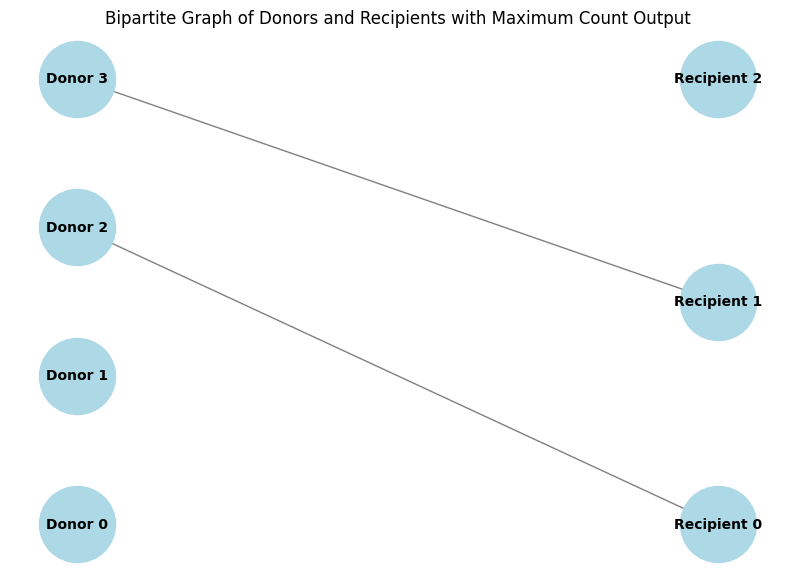

In [37]:
max_count_bitstring = "0011111"
print(max_count_bitstring)
donor_bits = max_count_bitstring[:num_donors]  # First 4 qubits for donors
recipient_bits = max_count_bitstring[num_donors:]  # Last 3 qubits for recipients
print(donor_bits,recipient_bits)
active_donors = [i for i, bit in enumerate(donor_bits) if bit == '1']
active_recipients = [i for i, bit in enumerate(recipient_bits) if bit == '1']
print(active_donors,active_recipients)
S = nx.Graph()
donor_nodes = [f"Donor {i}" for i in range(num_donors)]
recipient_nodes = [f"Recipient {j}" for j in range(num_receivers)]
S.add_nodes_from(donor_nodes, bipartite=0)
S.add_nodes_from(recipient_nodes, bipartite=1)

used_recipients = set()
for donor in active_donors:
    for recipient in active_recipients:
        # Ensure only one connection per donor and recipient
        if recipient not in used_recipients:
            S.add_edge(f"Donor {donor}", f"Recipient {recipient}")
            used_recipients.add(recipient)
            break 
        
positions = nx.bipartite_layout(S, donor_nodes)

plt.figure(figsize=(10, 7))
plt.title("Bipartite Graph of Donors and Recipients with Maximum Count Output")
nx.draw(S, positions, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
plt.show()


In [15]:

quantum_preds = []
for bitstring in counts:
    temp = []
    for pos, bit in enumerate(bitstring):
        if bit == '1':
            temp.append(pos)
    quantum_preds.append(temp)
print(quantum_preds)


[[3, 6], [0, 1, 3, 4, 5], [2, 3, 5, 6], [1, 2, 3, 4, 6], [1, 5, 6], [3, 4], [0, 1, 2], [0, 3, 4, 5], [1, 2, 3, 5, 6], [1, 4, 6], [0, 3, 4], [0, 1, 2, 4, 5], [0, 2, 5, 6], [0, 1, 5], [2, 3, 4, 5, 6], [4, 5, 6], [1, 2], [0, 6], [0, 1, 2, 3, 4, 6], [0, 1, 2, 6], [1, 6], [1, 2, 3, 4, 5, 6], [0, 1, 2, 5], [2, 3, 5], [0, 1, 4], [3, 4, 6], [0, 1, 2, 4, 5, 6], [0, 3, 5, 6], [0, 2, 3], [2, 4], [2, 4, 5, 6], [0, 1, 2, 4, 6], [1, 2, 3, 5], [1, 4, 5], [3, 4, 5, 6], [0, 1, 2, 3, 5], [0, 4], [1, 3, 5, 6], [1, 2, 4, 6], [4, 6], [0, 1, 2, 3, 4, 5, 6], [0, 5, 6], [0, 2, 3, 4, 5], [2, 4, 6], [0, 1, 2, 3, 5, 6], [0, 4, 5, 6], [6], [2, 3], [0, 2], [0, 2, 3, 5], [0, 1, 3], [5, 6], [1, 2, 4, 5, 6], [0, 1, 4, 6], [0, 1, 4, 5], [2, 3, 4], [0, 3, 4, 5, 6], [0, 1, 2, 5, 6], [1], [0, 2, 3, 5, 6], [0, 2, 4, 5, 6], [1, 2, 3], [2, 5, 6], [4, 5], [0, 1, 2, 3, 4, 5], [0], [0, 1, 2, 4], [0, 1], [0, 2, 4, 5], [0, 2, 3, 4, 6], [0, 1, 2, 3], [0, 1, 2, 3, 6], [1, 4], [0, 2, 3, 4, 5, 6], [3, 4, 5], [0, 4, 6], [0, 3], [0, 3

In [16]:
# Calculate classical cuts for comparison
sub_lists = []
for i in range(num_donors + num_receivers + 1):
    temp = [list(x) for x in combinations(B.nodes(), i)]
    sub_lists.extend(temp)

cut_classic = []
for sub_list in sub_lists:
    cut_classic.append(nx.algorithms.cuts.cut_size(B, sub_list, weight='weight'))

cut_quantum = []
for cut in quantum_preds:
    cut_quantum.append(nx.algorithms.cuts.cut_size(B, cut, weight='weight'))
    print(cut_quantum)

print("Quantum mean cut:", np.max(cut_quantum))
print("Max classical cut:", np.max(cut_classic))
print("Ratio:", np.max(cut_quantum) / np.max(cut_classic))

[1.4554203350383625]
[1.4554203350383625, 1.9973520440808343]
[1.4554203350383625, 1.9973520440808343, 2.234632575378928]
[1.4554203350383625, 1.9973520440808343, 2.234632575378928, 1.6296278439574998]
[1.4554203350383625, 1.9973520440808343, 2.234632575378928, 1.6296278439574998, 2.082636628732951]
[1.4554203350383625, 1.9973520440808343, 2.234632575378928, 1.6296278439574998, 2.082636628732951, 1.7528451982639386]
[1.4554203350383625, 1.9973520440808343, 2.234632575378928, 1.6296278439574998, 2.082636628732951, 1.7528451982639386, 3.418665585811925]
[1.4554203350383625, 1.9973520440808343, 2.234632575378928, 1.6296278439574998, 2.082636628732951, 1.7528451982639386, 3.418665585811925, 2.8618488690735164]
[1.4554203350383625, 1.9973520440808343, 2.234632575378928, 1.6296278439574998, 2.082636628732951, 1.7528451982639386, 3.418665585811925, 2.8618488690735164, 1.540704919690479]
[1.4554203350383625, 1.9973520440808343, 2.234632575378928, 1.6296278439574998, 2.082636628732951, 1.752845

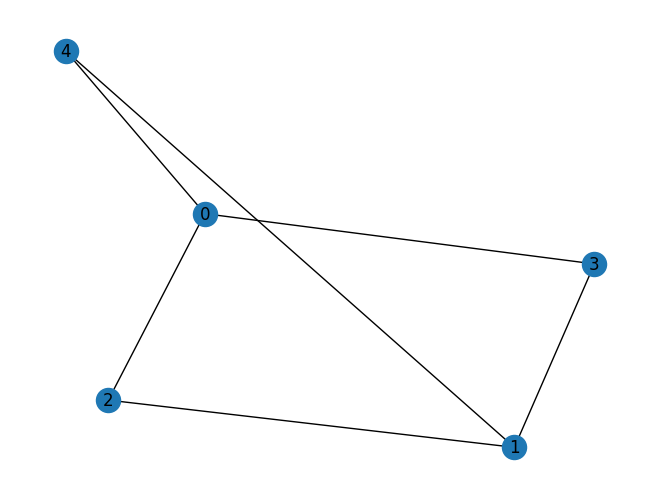